In [27]:
### Inclusions ###

rootf = ... ## Your folder ##
# put here the folder where all subfolders (diffRBM, Align utils, Immunogenicity_model etc. are saved)

import sys, os, pickle
sys.path.append(rootf + '/Notebooks/')
sys.path.append(rootf + '/diffRBM/source/')
sys.path.append(rootf + '/diffRBM/utilities/')

import utilities as utilities
import rbm as rbm
import diffrbm as diffrbm

import numpy as np
import pandas as pd
import importlib
import utilities_diffrbm

# Plots stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import patches
from pandas.plotting import table
mpl.rcParams['font.family'] = ['Garuda']
mpl.rcParams['font.serif'] = ['Garuda-Oblique']

import random
import sklearn
from sklearn import metrics
import math

## A series of useful functions ##

def align_seqs_seed(seed_seqs,new_seqs,SA,SAmin,SAmax):
    
    import subprocess, os
    name_mat = rootf + '/Align_utils/align_prot_to_seedpy.py'
    
    all_seqs1 = list(seed_seqs)
    name_seed = rootf + '/Align_utils/prots_seed.txt'
    with open(name_seed, 'w') as out_f:
        for u in range(len(all_seqs1)):
            if len(all_seqs1[u]) >= SAmin:  
                out_f.write(all_seqs1[u] + '\n')
                
    seqs_gapless = list(new_seqs)
    name_seqs = rootf + '/Align_utils/prots_seqs.txt'
    with open(name_seqs, 'w') as out_f:
        for u in range(len(seqs_gapless)):
            if len(seqs_gapless[u]) >= SAmin:  
                out_f.write(seqs_gapless[u] + '\n')
                
    subprocess.call('python3 ' + name_mat + ' -sseed ' + name_seed + ' -sseqs ' + name_seqs + ' -SA ' + str(SA) + ' -SAmin ' + str(SAmin) + ' -SAmax ' + str(SAmax) + ' -yw 0', shell = True)
    seqs_al = np.loadtxt(rootf + '/Align_utils/aligned_prot.txt')
    os.system('rm ' + rootf + '/Align_utils/aligned_prot.txt')
    
    return seqs_al

def flatten_list(listoflist):
    listoflist_fl = [];
    for l in range(len(listoflist)):
        for u in range(len(listoflist[l])):
            listoflist_fl.append(listoflist[l][u])
    return listoflist_fl
 
curr_int = np.int16
def convert_number(seqs): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadict = {aa[k]: k for k in range(len(aa))} 
    
    msa_num = np.array(list(map(lambda x: [aadict[y] for y in x], seqs[0:])), dtype=curr_int, order="c") ### Here change ####
    
    return msa_num

def convert_letter(seqs_n): # convert to numbers already aligned seqs
    aa = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V',  'W', 'Y','-']
    aadictinv = {k: aa[k] for k in range(len(aa))} 
    seqs=[]
    if type(seqs_n[0]) == curr_int:
        seqs.append(''.join([aadictinv[e] for e in seqs_n]))
    else:
        for t in range(len(seqs_n)):
            seqs.append(''.join([aadictinv[e] for e in seqs_n[t]]))
    return seqs

def diffrbm_predictions(HLA, name_file_test):

    dataset = 'IEDB_' + HLA ## This is the name of the folder with the model; if does not exist I create it 
    name_folder = rootf + '/Immunogenicity_model/' + dataset
    l1bB = 0.001
    n_hB = 10 
    mod = '_YesReal_0_hu_' + str(n_hB) + '_l12' + str(l1bB) + '_AL9.5_SA9_RWNoAlpha_TR1' # dataset and
    name_back = name_folder + '/presentation/model' + mod + '.data'
    RBM_back = RBM_utils.loadRBM(name_back)

    dataf = pd.read_csv(name_folder + '/presentation/Table_training' + mod + '.txt', sep='\t')
    all_cdr3 = list(dataf['Data aligned'].values)
    SA = 9
    SAmin = 8
    SAmax = 11
    pep_sel=[]
    with open(name_file_test) as f:
        for line in f:
            linesplit = line.strip().split('\n')
            pep_sel.append(linesplit[0])

    range_len = [len(s) for s in pep_sel]

    if len(np.unique(range_len))==1:
        seqs_n = convert_number(pep_sel)
    else:
        seqs_n = align_seqs_seed(all_cdr3,pep_sel,SA,SAmin,SAmax)

    name_mf = '/models_9.5_full'

    if HLA == 'HLA-A*02:01':
        name_top = name_folder + name_mf + '/topmodel_imm_RW0_ZFFalse_TR100_l2fields0.000598.data'
    if HLA == 'HLA-B*07:02':
        name_top = name_folder + name_mf + '/topmodel_imm_RW0_ZFFalse_TR100_l2fields0.003876.data'
    if HLA == 'HLA-B*35:01':
        name_top = name_folder + name_mf + '/topmodel_imm_RW0_ZFFalse_TR100_l2fields0.004651.data'

    ZF = False 
    visible = 'Potts' # Nature of visible units potential. Here, Potts states.
    hidden = 'dReLU'
    n_h_top = 10
    RBMpost = rbm.RBM(n_h = RBM_back.n_h + n_h_top, n_v = RBM_back.n_v, n_cv= RBM_back.n_cv, visible=visible, hidden=hidden, zero_field=ZF)
    dRBMf = diffrbm.DiffRBM(RBM_back, RBMpost)
    dRBMf.update_post_from_back(vlayer=True, hlayer=True)
    dRBMf =  RBM_utils.loadRBM(name_top)

    ## score ##
    scores = -dRBMf.top_rbm().free_energy(seqs_n.astype(np.int16))

    ## single-site factors ##
    RBMq = dRBMf.top_rbm()
    g_top = RBMq.vlayer.fields
    ss_factors=[]
    for N in range(len(seqs_n)):
        hm = RBMq.hlayer.mean_from_inputs(RBMq.vlayer.compute_output(seqs_n[N], RBMq.weights, direction ='up') , beta = 1)
        I_top = RBMq.hlayer.compute_output(hm, RBMq.weights, direction='down')
        ss_factors.append([g_top[i, seqs_n[N][i]] + sum(I_top[:,i, seqs_n[N][i]]) for i in range(SA)])
        
    return scores, ss_factors

In [28]:
## The function 'diffrbm_predictions' takes the immunogenicity model, calculates scores of 
## immunogenicity and single site factors under the model for the sequences
## in the file with name name_file_test

HLA = 'HLA-A*02:01'
name_file_test = rootf + '/Immunogenicity_example/Test_data.txt'

scores, ss_factors = diffrbm_predictions(HLA, name_file_test)

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


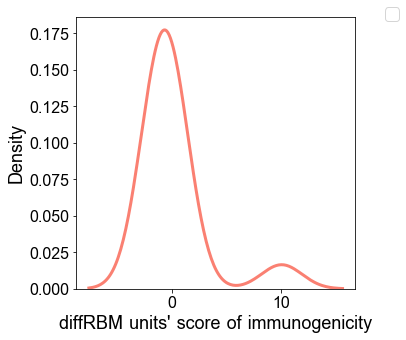

In [37]:
import seaborn as sns
s2=18
w=3
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
histv=False
sns.distplot(scores, hist = histv, kde_kws = {'linewidth': w}, color = 'Salmon', ax = ax);
ax.set_xlabel(r"diffRBM units' score of immunogenicity", fontsize=s2)
ax.set_ylabel('Density', fontsize=s2)
ax.legend(fontsize=s2, markerscale=3, frameon=True, loc='best', bbox_to_anchor=(1.19, 1.07))
ax.tick_params(axis='both', which='major', labelsize=s2-2)

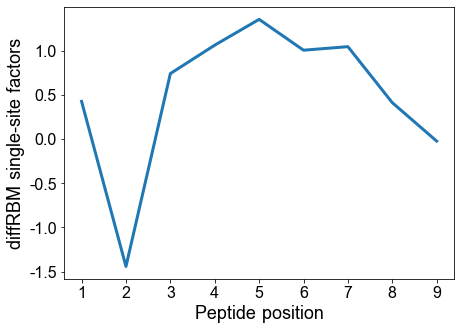

In [41]:
fig, ax =plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(7)

ax.set_ylabel('diffRBM single-site factors', fontsize = s2)
ax.set_xlabel('Peptide position', fontsize = s2)
ax.tick_params(axis='both', which='major', labelsize = s2-2)
ax.set_xticks(list(np.arange(SA)))
ax.set_xticklabels(list(np.arange(SA)+1))
ax.plot(np.arange(SA),ss_factors[1], lw=w)